<a href="https://colab.research.google.com/github/AndyNano/ML-MotEx/blob/main/Colab_ML-MotEx-Step3%2B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Welcome to step 3 and 4 of ML-MotEx </center></h1>

Use this script to take a organized structure catalogue with goodness-of-fit values and predict atom contribution values. The input has to be provided in the following format:

| ID | Rwp value | Number of atoms | Atom #1 | Atom #2 | ... | Atom #N |
|----|-----------|-----------------|---------|---------|-----|---------|
| 1  | 0.55      | 36              | 1       | 0       | ... | 1       |
| 2  | 0.23      | 23              | 0       | 1       | ... | 0       |

The input is used to train a XGBoost regressor and calculate atom contribution values based on the SHAP values of the features as explained in the below pseudo-code.

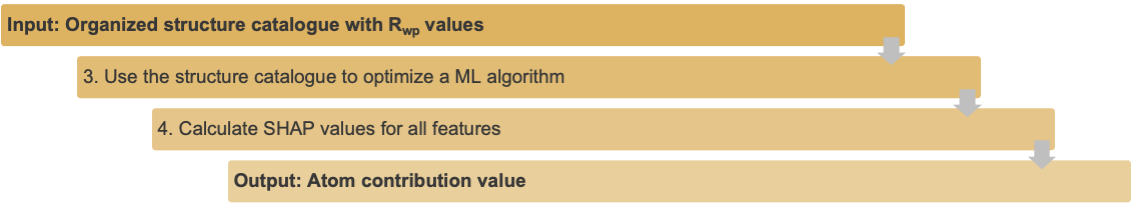

In [10]:
from IPython.display import Image
Image("Images/Algorithm_Step3_4.png")

The output is given as a list of atom contribution values providing information about how much each atom contributes to the goodness-of-fit.

# First import modules, set seed parameters and import functions

In [1]:
%%capture
!wget https://sid.erda.dk/share_redirect/AZZSDxCoh7
!unzip AZZSDxCoh7
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install shap;
import time, shap, os
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
!pip install bayesian-optimization;
from bayes_opt import BayesianOptimization
import pandas as pd
os.chdir("ML-MotEx")

np.random.seed(14)

In [2]:
def Import_Dataset(FileName):
    """This function loads a catalogue of structures with their corresponding Rwp values and split the dataset 
    into a training set and validation set with features and labels."""
    # load data
    dataset = np.loadtxt(FileName, delimiter=" ", skiprows=0)
    dataset_original = dataset.copy()

    # Split into training and validation set
    dataset_train = dataset[:int(len(dataset)*0.8)]
    dataset_val = dataset[int(len(dataset)*0.8):len(dataset)]
    
    # split data into features (X) and labels (y)
    X_train = dataset_train[:,2:len(dataset)+1]
    y_train = dataset_train[:,1]
    X_val = dataset_val[:,2:len(dataset)+1]
    y_val = dataset_val[:,1]
    
    print("Number of Training Data:", len(y_train))
    print("Number of Validation Data:", len(y_val))
        
    return X_train, y_train, X_val, y_val
    
def Validate_XGBoost(model, X_val, y_val):
    """Function to validate the performance of the XGBoost algorithm on a validation set"""
    print ("Giving an estimate of the accuracy of the model")
    xgb_val = xgb.DMatrix(X_val, y_val)
    y_pred_val = model.predict(xgb_val)
    rmse = mean_squared_error(y_val, y_pred_val)
    print("RMSE: %f" % (rmse))
    return rmse

def DecisionTree_CrossValidation(learning_rate, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=0, 
                                       learning_rate = learning_rate,
                                       max_depth=max_depth) 
    
    cval = cross_val_score(estimator, data, targets, cv=3)
    return cval.mean()

def optimize_DecisionTree(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate, max_depth):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        accuracy_mean = DecisionTree_CrossValidation(learning_rate = learning_rate,
                                       max_depth=int(max_depth), 
                                       data=data, targets=targets)
        
        return accuracy_mean
    
    optimizer = BayesianOptimization(f=crossval_wrapper, pbounds=pars, 
                                     random_state=0, verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

def train_w_earlyStop(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, early_stop, xgb_model=None):
    """Train a XGBoost model using the given parameters. The training will run until the early stop criteria is
    fulfilled or 5000 epochs are run. The loss curve and values is saved."""
    start_time = time.time()

    xgb_params = {}
    xgb_params['learning_rate'] = learning_rate
    xgb_params['objective'] = 'reg:squarederror' # Default
    xgb_params['max_depth'] = max_depth
    xgb_params['n_estimators'] = n_estimators
    xgb_params['n_jobs'] = n_jobs
    xgb_params['gamma'] = gamma
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['eval_metric'] = ['mae']
    xgb_params['base_score'] = base_score
    xgb_params['seed'] = seed
    xgb_params['verbosity'] = 0
    epochs = 5000

    store = {}
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_val = xgb.DMatrix(X_val, y_val)
    evallist = [(xgb_train,'train'),(xgb_val, 'val')]
    model = None

    model = xgb.train(xgb_params, xgb_train, epochs, evallist, evals_result=store, verbose_eval=0, early_stopping_rounds=early_stop, xgb_model=model)
    print ("Training using the best parameters")
    print("Total execution time: %.3f s" % (time.time()-start_time))
    print ("Training succeeded")
    
    # Save Loss
    loss_results = pd.DataFrame(store)
    loss_results.to_csv("ML_algorithms/LossCurve.csv")

    # Plot Loss
    test_score = store['val']['mae']
    train_score = store['train']['mae']
    plt.plot(range(len(test_score)), test_score, "c", label="Val")
    plt.plot(range(len(train_score)), train_score, "orange", label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("MAE Loss")
    plt.legend()
    plt.savefig("ML_algorithms/LossCurve.png")
    return model, store

def shap_essential_figure(model, X_train, saveResults):
    """Function that takes a XGBoost model, a training set and calculates SHAP values of each features in the 
    training set. Afterwards, it saves a SHAP summary plot"""
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) 
    # Make SHAP summary plot
    shap.summary_plot(shap_values[:,1:], X_train[:,1:], feature_names=["Atom #"+str(i) for i in range(1,X_train.shape[1])], color_bar_label="Feature Value (Low: Atom Removed, High: Atom Not Removed)", show=False, max_display=X_train.shape[1]) # to plot these explanations
    plt.savefig(saveResults + "/SHAP_values.png", dpi=600, format = "png", bbox_inches='tight')
    return explainer, shap_values

def calculate_atomContributionValue(shap_values, X_train, saveResults):
    """Calculate atom contribution value list from shap values and training set"""
    AtomContributionValues = []
    AtomContributionValues_RMS = []
    for i in range(X_train.shape[1]):
        # We are not interested in the number of atoms in this regi
        if i == 0:
            AtomContributionValues.append(0)
            AtomContributionValues_RMS.append(0)
        else:
            Keep_atoms = np.mean((shap_values[np.where(X_train[:,i] == 1),i]))
            Keep_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 1),i]))
            Remove_atoms = np.mean((shap_values[np.where(X_train[:,i] == 0),i]))
            Remove_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 0),i]))
            AtomContributionValues.append(0.5*Keep_atoms - 0.5*Remove_atoms)
            AtomContributionValues_RMS.append(np.sqrt((0.5*Keep_atoms)**2 + (0.5*Remove_atoms)**2))
    np.savetxt(saveResults + "/AtomContributionValues.txt", AtomContributionValues[1:])
    
    Norm_AtomContributionValues = AtomContributionValues.copy()
    # Normalise the AtomContributionValues and get the RGB color in viridis.reverse
    amin, amax = min(Norm_AtomContributionValues), max(Norm_AtomContributionValues)
    for i, val in enumerate(Norm_AtomContributionValues):
        Norm_AtomContributionValues[i] = (val-amin) / (amax-amin)
    Norm_AtomContributionValues_ph = Norm_AtomContributionValues.copy()
    Norm_AtomContributionValues_ph.sort()
    
    # Normalise such that a threshold is set on the the 10 % lowest and 10 % highest atoms
    norm = mpl.colors.Normalize(vmin=Norm_AtomContributionValues_ph[round((len(Norm_AtomContributionValues))/10)], vmax=Norm_AtomContributionValues_ph[-round((len(Norm_AtomContributionValues))/10)])
    cmap = mpl.cm.cividis_r
    
    print ("Atom contribution are calculated to: ")
    for i in range(1,len(AtomContributionValues)):
        m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        print ("Atom #", str(i) + ": ", str(AtomContributionValues[i]) + " ± " + str(AtomContributionValues_RMS[i]), " Colorcode: ", mpl.colors.rgb2hex(m.to_rgba(Norm_AtomContributionValues[i])))
    
    return AtomContributionValues


# Step 3: Train a XGBoost Regressor to predict the Rwp value based on the structure catalogue
### First define the path of the organized structure catalogue with Rwp values and set range for model optimization. 

It can take a few minutes to train thee XGBoost model. 
N_iter gives a measure of how rounds the model should try to optimize. Set to a low number for a less accurate but fast convergence. 

Number of Training Data: 8000
Number of Validation Data: 2000
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
[14:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  1        |  0.9654   |  0.4842   |  7.722    |
[14:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  2        |  0.9732   | 

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Training using the best parameters
Total execution time: 10.296 s
Training succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.000104


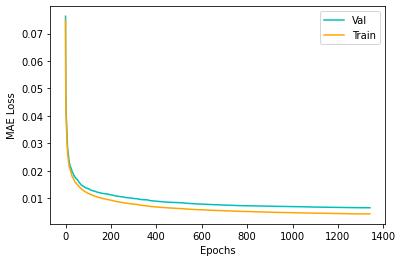

In [4]:
saveFits = "Training_Data/structure_109725.txt" # Name of the saved fits file
Min_LR = 0.1 # Minimum learning rate for the XGBoost algorithm
Max_LR = 0.8 # Maximum learning rate for the XGBoost algorithm
Min_Dep = 2 # Minimum max depth for the XGBoost algorithm
Max_Dep = 10 # Maximum max depth for the XGBoost algorithm
n_iter = 50 # Number of iterations for the bayesian optimization model

# Import dataset
X_train, y_train, X_val, y_val = Import_Dataset(saveFits)

# Make a dictionary of parameters we should optimize for the ML algorithm
parameters_BayesianOptimization = {"learning_rate": (Min_LR, Max_LR), #0.1 is default - Boosting learning rate
                                   "max_depth": (Min_Dep, Max_Dep)}  #3 is default - Maximum tree depth for base learners.

# Finding the best parameters for the ML model
BayesianOptimization_func = optimize_DecisionTree(X_train, y_train, parameters_BayesianOptimization, n_iter=n_iter)
print("Best parameters were: ", BayesianOptimization_func.max)


# Get best parameters for the ML model and make max depth to an integer
params = BayesianOptimization_func.max['params']
params['max_depth'] = int(params['max_depth'])

#  Define model, train and validate the model and save model
model, store = train_w_earlyStop(X_train, y_train, n_jobs=1, seed=0, base_score=0.5, n_estimators=100, gamma=0, min_child_weight=1, early_stop=50, **params);
Validate_XGBoost(model, X_val, y_val);
model.save_model("ML_algorithms/109725_XGB_model.dat");


# Step 4: Calculate atom contribution values
### Define the path of where the SHAP values and atom contribution values should be saved. 



Atom contribution are calculated to: 
Atom # 1:  -0.01590430224314332 ± 0.01125316771409686  Colorcode:  #ebd44b
Atom # 2:  0.01197317661717534 ± 0.008483889336646377  Colorcode:  #002859
Atom # 3:  -0.019246415235102177 ± 0.013784545807083102  Colorcode:  #fee838
Atom # 4:  0.012897614389657974 ± 0.009256167513026114  Colorcode:  #00224e
Atom # 5:  -0.013552805408835411 ± 0.009617581300364454  Colorcode:  #d6c35d
Atom # 6:  0.005894932663068175 ± 0.004232625939013527  Colorcode:  #3c4a6c
Atom # 7:  -0.015835268888622522 ± 0.011200842944403938  Colorcode:  #ebd44b
Atom # 8:  0.011238436214625835 ± 0.00811684468091878  Colorcode:  #002c64
Atom # 9:  -0.0182571429759264 ± 0.012967644002789689  Colorcode:  #fee838
Atom # 10:  0.013007916510105133 ± 0.009328600437814473  Colorcode:  #00224e
Atom # 11:  -0.01351678790524602 ± 0.009608648079730294  Colorcode:  #d6c35d
Atom # 12:  0.006694636074826121 ± 0.00475600549124868  Colorcode:  #35456c
Atom # 13:  -0.015008621849119663 ± 0.01067548595

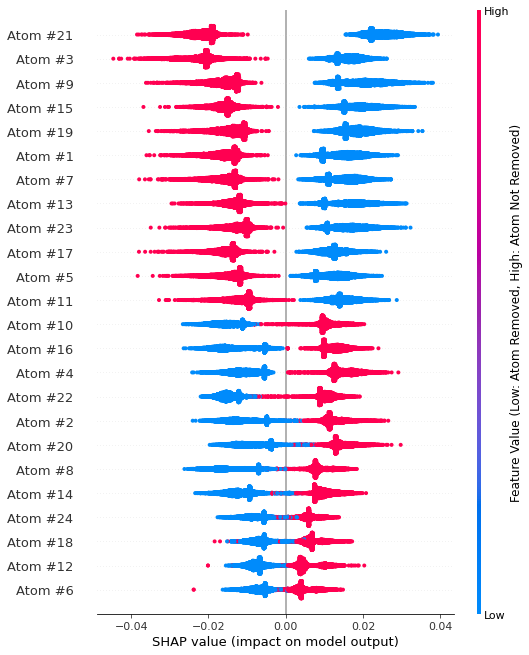

In [5]:
saveResults = "Results/"

# Calculate SHAP values and save to savePATH.
explainer, shap_values = shap_essential_figure(model, X_train, saveResults)

# Calculate atom contribution values
AtomContributionValues = calculate_atomContributionValue(shap_values, X_train, saveResults)



# Extra



### We can now make a structure based on the atom contribution values 

As we saw in the script "ML-MotEx-Step1+2", the brute-force approach does not find an alpha-Keggin cluster as the best model. 

Using ML-MotEx, we can now decide which atoms to keep in the model based on the atom contribution value. Here we choose a threshold of 0 meaning that all atoms that contribute to lowering the goodness-of-fit is kept in the model. By doings so, we get a better fit than found with the brute-force model and we obtain the alpha-Keggin cluster. Both the fit from the brute-force model and the structure found with ML-MotEx are shown in the script "ML-MotEx-Step1+2".


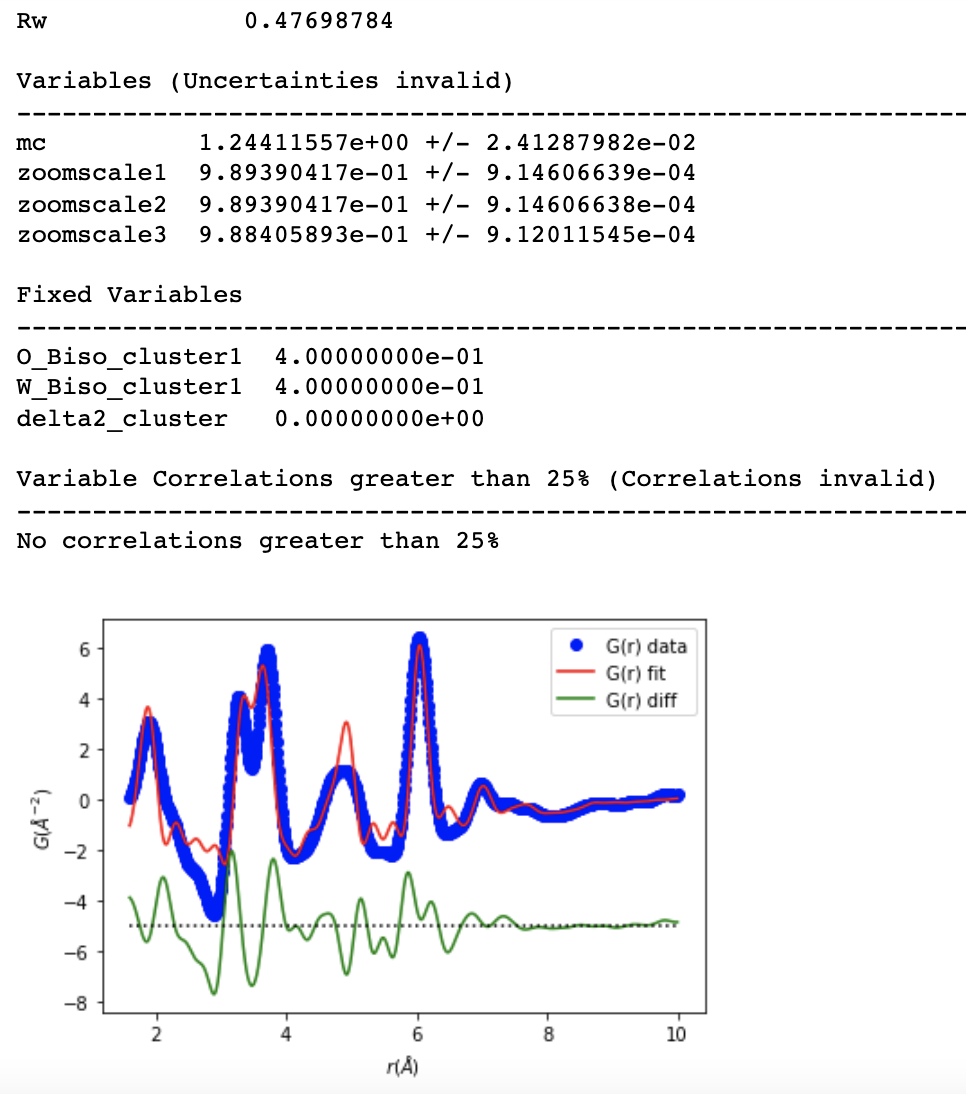

In [6]:
Image("Images/ML-MotEx_Structure.png")